In [16]:
import serial
import time
import threading
import numpy as np

# Configuration
printer_volume_x = 250  # Printer build volume in X (in mm)
printer_volume_y = 250  # Printer build volume in Y (in mm)

printer_port = "/dev/ttyUSB0"    # Printer's serial port
teensy_port = "/dev/ttyACM0"     # Teensy's serial port
baud_rate_printer = 115200       # Baud rate for both devices
baud_rate_teensy = 2000000       # Baud rate for both devices
scale_factor = 16384.0           # Scale factor for raw data to g conversion
pause_time = 0.01                # Pause between G-code commands


# Global flag to signal the end of G-code sending
send_move_gcode = False
send_gcode_done = False

min_speed = 2000        # Minimum speed in mm/min
max_speed = 8000        # Maximum speed in mm/min
speed_increment = 100   # Speed increment in mm/min
speed_repeat = 2        # Number of repetitions at each speed level
settling_time = 200     # Settling time in milliseconds after each movement
start, end = 120, 130   # Start and end positions for axis

def generate_gcode(axis, axis_center, min_speed, max_speed, speed_increment, speed_repeat, settling_time, start, end):
    """Generate G-code commands for resonance testing."""
    
    gcode = []
    gcode.append("G28")  # Home all axes
    gcode.append("G90")  # Absolute positioning
    gcode.append("G1 Z30 F3000")  # Move to safe height
    gcode.append(f"G1 {axis}{axis_center} F3000")  # Move to axis center

    # Generate movements with varying speeds
    speed = min_speed
    while speed <= max_speed:
        
        for _ in range(speed_repeat):
            gcode.append(f"G1 {axis}{start} F{speed}")  # Move to start position
            gcode.append(f"G1 {axis}{end} F{speed}")    # Move to end position
            gcode.append(f"G1 {axis}{end} F1")          # Hold position at very low speed
            gcode.append(f"G4 P{settling_time}")        # Pause

        speed += speed_increment

    gcode.append("G28")  # Home all axes
    gcode.append("M18")  # Disable motors
    return gcode


def send_gcode(serial_port, baud_rate, gcode, pause_time):
    """Send G-code commands to the printer."""
    
    global send_move_gcode
    global send_gcode_done
    
    try:
        ser = serial.Serial(serial_port, baud_rate, timeout=2)
        time.sleep(0.5)
        print(f"Connected to {serial_port}")

        for line in gcode:
            #print(f"Sending: {line}")
            ser.write((line + "\n").encode())
            time.sleep(pause_time)

            # Read and handle response
            response = ser.readline().decode().strip()
            if response:
                
                if "G1" in line and "ok" in response and not send_move_gcode: 
                    print("Start recording")
                    send_move_gcode = True

                #print(f"Response: {response}")
                if "busy: processing" in response:
                    time.sleep(pause_time)  # Additional delay for busy response

        print("G-code complete.")

    except serial.SerialException as e:
        print(f"Error: {e}")

    finally:
        if 'ser' in locals() and ser.is_open:
            ser.close()
        send_gcode_done = True

def record_data(teensy_port, baud_rate, scale_factor):
    """Record measurement data from the Teensy."""
    
    global send_move_gcode
    global send_gcode_done
    
    # Lists to store data
    timestamps = []
    accel_x = []
    accel_y = []
    accel_z = []

    while not send_move_gcode: pass
    
    try:
        with serial.Serial(teensy_port, baud_rate, timeout=1) as ser:
            print(f"Connected to Teensy on {teensy_port}")

            start_time = time.time()

            while not send_gcode_done:
                line = ser.readline().decode('utf-8').strip()
                if line:
                    try:
                        # Parse raw data (X, Y, Z) from Teensy
                        x, y, z = map(int, line.split(","))
                        accel_x.append(x / scale_factor)
                        accel_y.append(y / scale_factor)
                        accel_z.append(z / scale_factor)
                        timestamps.append(time.time() - start_time)
                    except ValueError:
                        print(f"Invalid line: {line}")

            print("Data collection complete.")

    except serial.SerialException as e:
        print(f"Error reading data: {e}")

    data = np.column_stack((timestamps, accel_x, accel_y, accel_z))
    np.savetxt("teensy_data.csv", data, delimiter=",", header="Time,X,Y,Z", comments="")
    print("Data saved to teensy_data.csv")


# User choice for axis
axis_choice = input("Enter axis to test (X or Y): ").strip().upper()
if axis_choice == "X":
    gcode = generate_gcode("X", printer_volume_x/2 ,min_speed, max_speed, speed_increment, speed_repeat, settling_time, start, end)
elif axis_choice == "Y":
    gcode = generate_gcode("Y", printer_volume_y/2, min_speed, max_speed, speed_increment, speed_repeat, settling_time, start, end)
else:
    print("Invalid axis choice. Please choose either X or Y.")
    exit()


# Start G-code and data logging threads
gcode_thread = threading.Thread(target=send_gcode, args=(printer_port, baud_rate_printer, gcode, pause_time))
data_thread = threading.Thread(target=record_data, args=(teensy_port, baud_rate_teensy, scale_factor))

gcode_thread.start()
data_thread.start()

gcode_thread.join()
data_thread.join()

print("Parallel G-code sending and data logging complete.")



Connected to /dev/ttyUSB0
Start recording
Connected to Teensy on /dev/ttyACM0
Invalid line: ,1336,14640
Invalid line: 1008,-980,11740,72,15044
G-code complete.
Data collection complete.
Data saved to teensy_data.csv
Parallel G-code sending and data logging complete.


Top 5 Dominant Peaks (Frequency, Amplitude):
Frequency: 49.09 Hz, Amplitude: 2898.88
Frequency: 48.07 Hz, Amplitude: 2776.88
Frequency: 46.42 Hz, Amplitude: 2697.72
Frequency: 44.33 Hz, Amplitude: 1952.90
Frequency: 50.29 Hz, Amplitude: 1868.65


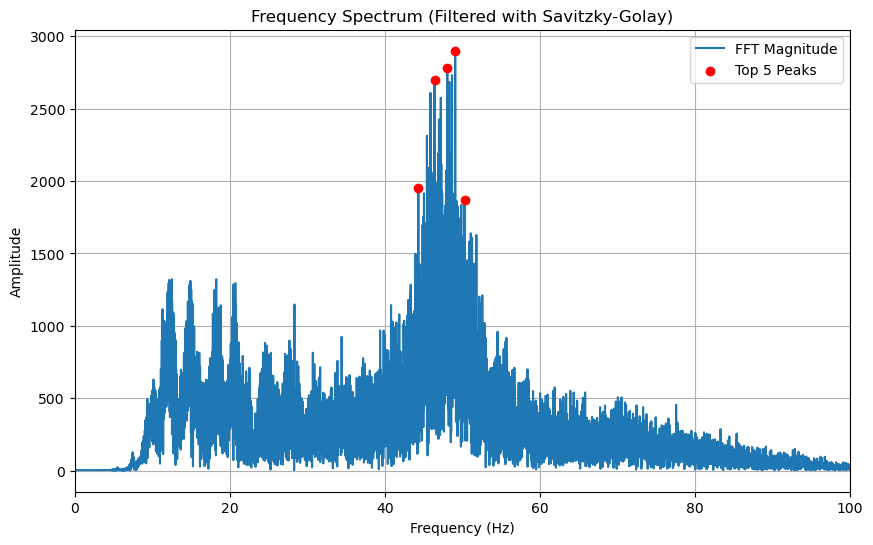

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.signal import butter, filtfilt, find_peaks, savgol_filter

# Load data from CSV file
data = np.loadtxt("teensy_data.csv", delimiter=",", skiprows=1)  # Replace with your CSV file name
timestamps = data[:, 0]  # First column: Timestamps
accel_x = data[:, 1]     # Second column: X-axis acceleration

# Define maximum frequency for peak detection
min_frequency = 10      # Hz
max_frequency = 100     # Hz
min_peak_distance = 1   # Minimum frequency separation in Hz

freq_plot_span = [0, 100]

# Calculate sampling rate (Fs) from timestamps
sampling_interval = np.mean(np.diff(timestamps))
Fs = 1 / sampling_interval  # Sampling frequency in Hz

# Band-pass filter
def band_pass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band', analog=False)
    return filtfilt(b, a, data)

# Apply band-pass filter (example: 5-150 Hz)
filtered_accel_x = band_pass_filter(accel_x, lowcut=min_frequency, highcut=max_frequency, fs=Fs, order=4)

# Apply Savitzky-Golay filter for smoothing
# Window length must be odd and less than the length of the data
savgol_filtered_accel_x = savgol_filter(filtered_accel_x, window_length=101, polyorder=4)

# Perform FFT on Savitzky-Golay filtered data
N = len(savgol_filtered_accel_x)
fft_values = fft(savgol_filtered_accel_x)
fft_magnitudes = np.abs(fft_values[:N // 2])
freqs = np.fft.fftfreq(N, d=sampling_interval)[:N // 2]

# Find peaks in the limited frequency range
min_bin_distance = int(min_peak_distance / (Fs / N))  # Convert to bins

peak_indices, _ = find_peaks(
    fft_magnitudes, 
    height=np.max(fft_magnitudes) * 0.1, 
    distance=min_bin_distance
)
peak_frequencies = freqs[peak_indices]
peak_magnitudes = fft_magnitudes[peak_indices]

# Sort peaks by magnitude and limit to top 5
sorted_indices = np.argsort(peak_magnitudes)[::-1]
top_n = 5  # Limit to top 5 peaks
peak_frequencies = peak_frequencies[sorted_indices][:top_n]
peak_magnitudes = peak_magnitudes[sorted_indices][:top_n]

# Output the top 5 peaks
print("Top 5 Dominant Peaks (Frequency, Amplitude):")
for freq, mag in zip(peak_frequencies, peak_magnitudes):
    print(f"Frequency: {freq:.2f} Hz, Amplitude: {mag:.2f}")

# Plot the frequency spectrum with top 5 peaks highlighted
plt.figure(figsize=(10, 6))
plt.plot(freqs, fft_magnitudes, label="FFT Magnitude")
plt.scatter(peak_frequencies, peak_magnitudes, color="red", label="Top 5 Peaks", zorder=5)
plt.xlim(freq_plot_span) 
plt.title("Frequency Spectrum (Filtered with Savitzky-Golay)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()